# What is SHAP?
SHAP is a tool used to aid in model interpretations. SHAP deconstructs the model, and tells us why the model made each prediction.



In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display='text')
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)

## Plot style
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
#Function for Evaluating Classification Models

def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

In [3]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [4]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [5]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [6]:
# let's create a custom function to plot our importances:

def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [7]:
## Load in the student performance - Portuguese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"
df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


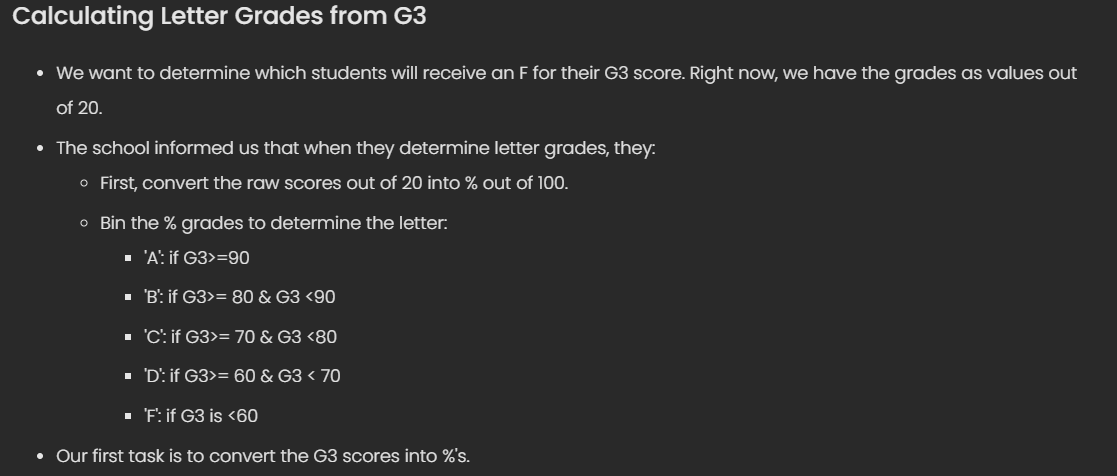

In [8]:
## convert G3 to a % out of 100
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()

0    55.0
1    55.0
2    60.0
3    70.0
4    65.0
Name: G3(%), dtype: float64

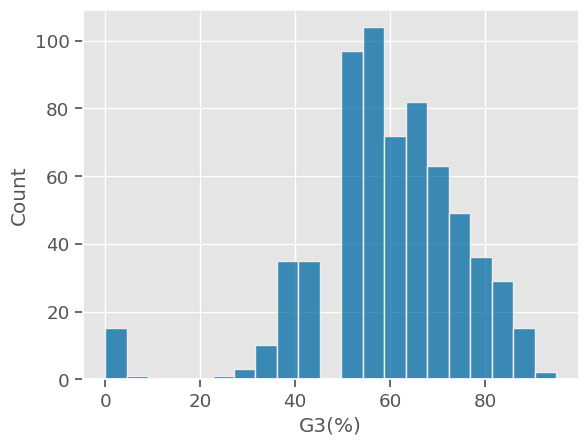

In [9]:
## visual distribution of % grades
ax = sns.histplot(data=df, x='G3(%)')

In [10]:
## defining bin edges
bins = [0,60,70,80,90,100]
grades = pd.cut(df['G3(%)'], bins=bins)
grades.value_counts().sort_index()

(0, 60]      358
(60, 70]     145
(70, 80]      85
(80, 90]      44
(90, 100]      2
Name: G3(%), dtype: int64

In [11]:
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts(dropna=False)

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 100)     17
Name: G3(%), dtype: int64

In [12]:
bins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 101)     17
Name: G3(%), dtype: int64

In [13]:
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
grades = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
grades.value_counts()

F    373
D    145
C     85
B     44
A      2
Name: G3(%), dtype: int64

In [14]:
df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,55.0,F
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,55.0,F
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,60.0,F
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14,70.0,D
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13,65.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4,10,11,10,50.0,F
645,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4,15,15,16,80.0,C
646,MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6,11,12,9,45.0,F
647,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,6,10,10,10,50.0,F


In [15]:
## We can group by the letter grades and get the min/max of the scores to confirm 
df.groupby('FinalGrade')['G3(%)'].agg(['min','max','count'])

,min,max,count
FinalGrade,,,
F,0.0,60.0,373
D,65.0,70.0,145
C,75.0,80.0,85
B,85.0,90.0,44
A,95.0,95.0,2


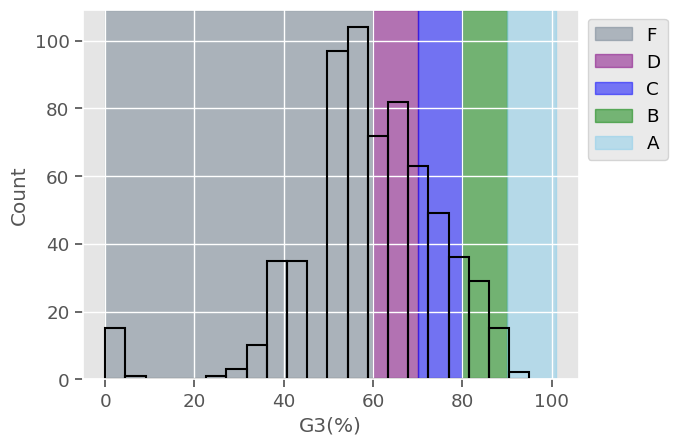

In [16]:
## visualizing the cutoffs for grades
ax = sns.histplot(data=df, x='G3(%)',color='k',fill=False)
colors = ['slategray','purple','blue','green','skyblue']
for i in range(len(bins)-1):
    x1 = bins[i]
    x2 = bins[i+1]
    label = bin_labels[i]
    ax.axvspan(x1,x2, label=label,color=colors[i],zorder=0,alpha=.5)
ax.legend(bbox_to_anchor=[1,1])

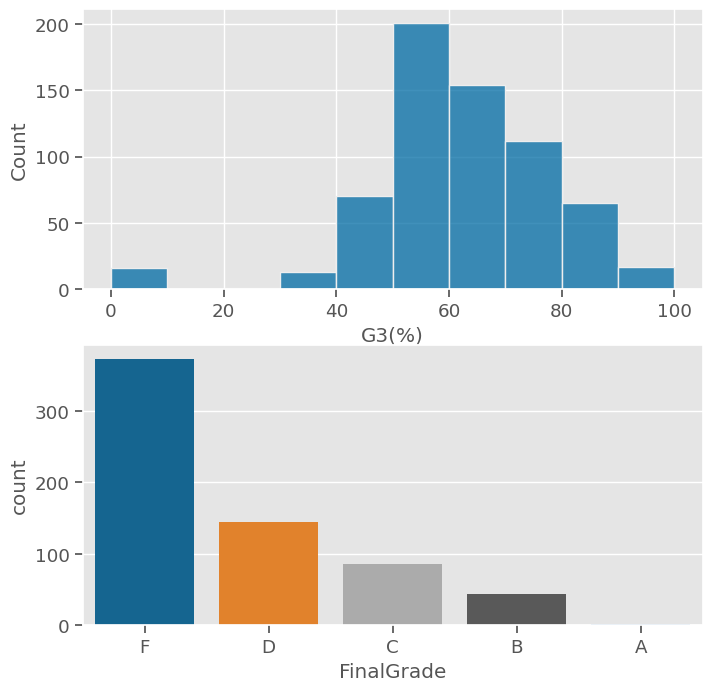

In [17]:
fig, axes = plt.subplots(nrows=2,figsize=(8,8))
sns.histplot(data=df, x='G3(%)',ax=axes[0], binwidth=10);
sns.countplot(data=df,x='FinalGrade',ax=axes[1],order=['F','D','C','B','A']);

# Making Our Final Target & X/y Data


In [18]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(normalize=True)

True     0.57473
False    0.42527
Name: target_F, dtype: float64

In [19]:
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                     fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head()

D:\Anaconda\envs\dojo-env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
540,17.0,3.0,2.0,2.0,1.0,0.0,4.0,3.0,3.0,2.0,2.0,1.0,5.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
309,18.0,4.0,2.0,1.0,2.0,0.0,5.0,4.0,5.0,1.0,3.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



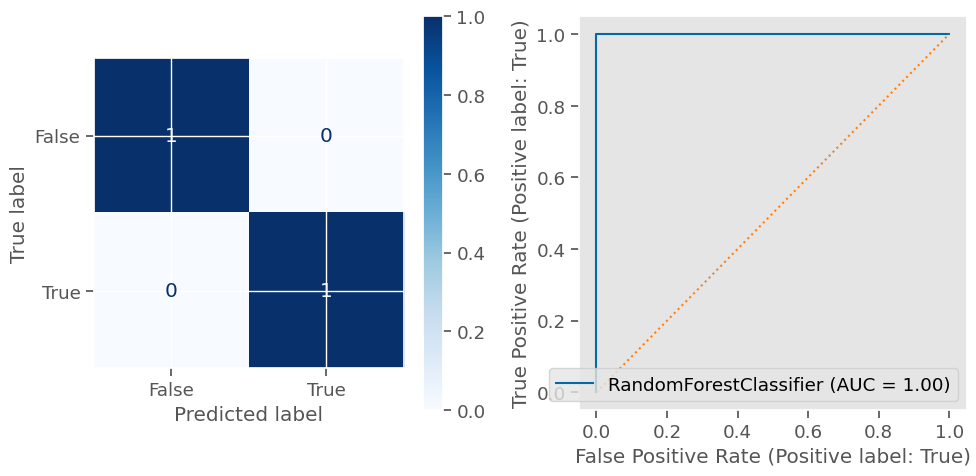

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



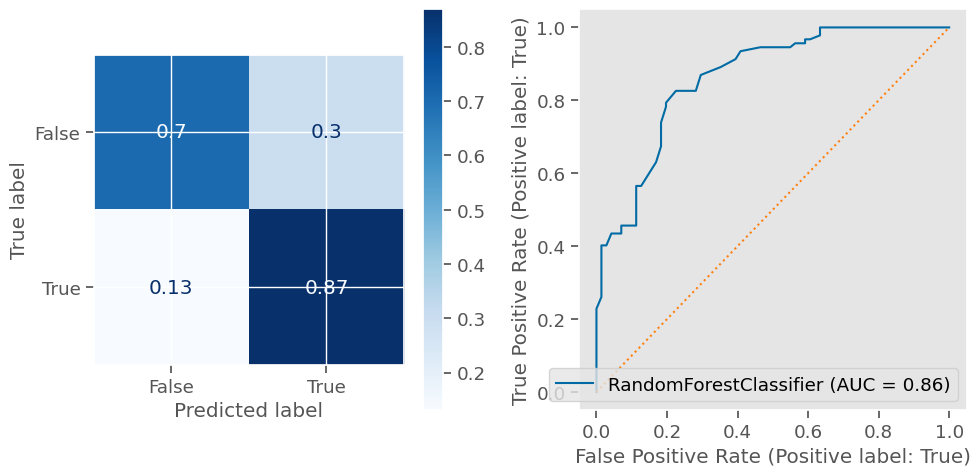

In [20]:
rf_clf = RandomForestClassifier()#class_weight='balanced')
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

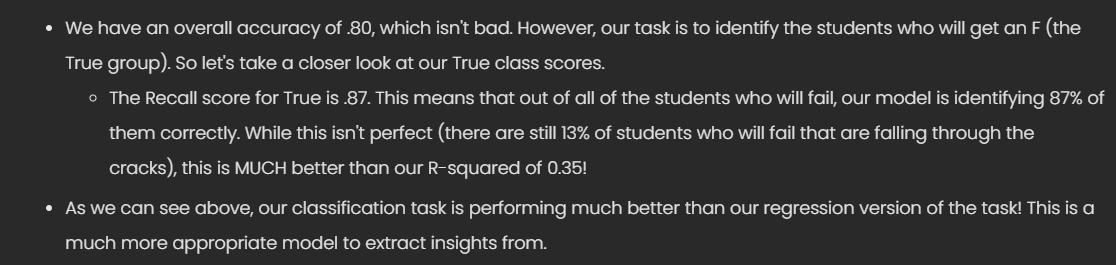

# Use SHAP

In [21]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [22]:
len(X_train_df)

# 486 may be fine, or it could be a bit much for your local machine.
#Whenever the dataset is too large for your machine to process in a timely manner, 
#we can use SHAP's utility for sampling a subset of our data (shap.sample).
#Let's take just 400 observations from our X_train_df and save it as X_shap.


486

In [23]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=321)
X_shap.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
473,16.0,2.0,1.0,2.0,1.0,0.0,2.0,4.0,3.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
340,17.0,3.0,3.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
452,16.0,2.0,2.0,3.0,2.0,0.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
555,16.0,1.0,2.0,1.0,3.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
70,16.0,3.0,1.0,2.0,4.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [24]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

473     True
340    False
452     True
555    False
70      True
       ...  
485     True
329    False
251     True
434     True
568     True
Name: target_F, Length: 400, dtype: bool

# Explaining Our RandomForest


## 1. Create a SHAP explainer using your fit model

In [25]:
explainer = shap.Explainer(rf_clf)
explainer

- As we can see above, shap.Explainer recognized that we are using a tree based model, so it created a TreeExplainer.
- Now that we have the explainer, we need to provide then X and y data.
- The explainer will use a copy of our model to iterate through all of the features to calculate the marginal contribution of each feature to the model's predictions.
- These contributions will be represented as SHAP values, which we will interpret to explain our model.

## 2. Get SHAP values from explainer for your training data

In [26]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [27]:
shap_values.shape

(400, 43, 2)

- The SHAP values also have a third dimension.
- Notice that the 3rd dimension is 2.
- This is because our classification task has 2 classes. If we had more classes, we would have the same number in our third dimension as we have classes.
- We actually have two SHAP values for every sample and feature (one for each target class)

# Exploring SHAP Explanation Values

In [28]:
shap_values[0]

.values =
array([[-1.15165368e-02,  1.15165368e-02],
       [-2.00970183e-02,  2.00970183e-02],
       [-3.73278511e-02,  3.73278511e-02],
       [-1.30577180e-02,  1.30577180e-02],
       [-6.02032650e-02,  6.02032650e-02],
       [ 1.82659012e-02, -1.82659012e-02],
       [-2.60672307e-02,  2.60672307e-02],
       [-5.23592261e-03,  5.23592261e-03],
       [-1.03872516e-02,  1.03872516e-02],
       [-2.83196172e-02,  2.83196172e-02],
       [-2.07484363e-02,  2.07484363e-02],
       [-5.73616057e-03,  5.73616057e-03],
       [-1.13086674e-02,  1.13086674e-02],
       [-4.39675434e-02,  4.39675434e-02],
       [-3.55386270e-02,  3.55386270e-02],
       [ 1.27171520e-03, -1.27171520e-03],
       [-5.32930678e-03,  5.32930678e-03],
       [-2.30715695e-03,  2.30715695e-03],
       [-4.69512766e-02,  4.69512766e-02],
       [-1.45327285e-03,  1.45327285e-03],
       [-5.67660591e-03,  5.67660591e-03],
       [-3.72593331e-04,  3.72593331e-04],
       [-2.87157566e-03,  2.87157566e-03],
 

In [29]:
# slicing for failing values 
shap_vals_1 = shap_values[:,:,1]
shap_vals_1.shape

(400, 43)

In [30]:
pd.DataFrame(shap_vals_1.values, columns = X_shap.columns)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,0.011517,0.020097,0.037328,0.013058,0.060203,-0.018266,0.026067,0.005236,0.010387,0.028320,0.020748,0.005736,0.011309,0.043968,0.035539,-0.001272,0.005329,0.002307,0.046951,0.001453,0.005677,0.000373,0.002872,-0.000225,0.000057,-0.001143,0.000815,0.005247,0.015226,0.004208,-0.001029,0.007523,0.000662,0.001909,0.000386,-0.001690,0.007628,-0.000286,0.002959,-0.001125,-0.010127,-0.000757,-0.001594
1,-0.027303,-0.009091,-0.031383,-0.010162,0.049549,-0.033083,-0.014626,-0.004118,0.003253,-0.031235,0.004435,0.017833,-0.049344,-0.040682,0.025022,-0.011379,-0.003799,0.002595,-0.017070,-0.035362,-0.001404,-0.003323,-0.007938,-0.001239,-0.001395,-0.010251,-0.006474,0.003280,-0.015919,-0.028659,-0.004538,0.004828,-0.003888,-0.007049,0.000052,-0.006882,0.005054,-0.004694,-0.004045,-0.008982,-0.023219,-0.001126,-0.002661
2,0.017169,0.032987,0.019626,-0.015481,0.007520,-0.026687,-0.007202,0.025579,0.040698,-0.015929,0.001173,0.003841,0.025080,0.080948,-0.011251,0.038092,0.007363,0.001380,-0.007668,0.002596,-0.005117,0.001234,0.003561,-0.000647,-0.000297,0.021454,0.013906,0.004540,0.027574,0.004750,-0.001471,0.007297,0.004914,0.005234,-0.000168,-0.001349,0.007637,-0.000833,0.007627,0.004793,-0.014682,0.000407,-0.006618
3,0.001809,-0.001358,-0.001983,0.008710,-0.099199,-0.034132,-0.010260,-0.004445,-0.006709,-0.023644,-0.010326,-0.008269,0.007948,0.008614,-0.017645,-0.004299,-0.001429,0.001784,-0.011344,0.001983,-0.005672,-0.001386,-0.000014,-0.000376,-0.001226,0.005254,0.002630,0.001950,-0.022413,-0.033509,-0.004206,-0.005627,-0.008104,-0.006877,-0.001257,0.010184,-0.002114,-0.001120,0.000369,-0.008371,-0.018657,-0.017193,0.005509
4,0.023117,0.035304,0.043111,0.002672,-0.006079,-0.025589,0.000259,0.027685,-0.012348,-0.006155,-0.003187,0.038435,0.014096,-0.001177,0.052577,-0.004504,-0.000448,0.004517,-0.001922,0.003276,0.005726,0.001250,0.002838,0.000213,-0.000518,0.014882,0.004071,0.003847,-0.005173,0.007281,-0.000556,-0.010176,0.011737,0.022177,-0.000538,-0.005201,0.006749,-0.001681,0.017924,-0.002532,-0.014325,0.000894,0.001052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.005944,0.032713,0.010837,0.017512,0.015403,-0.029194,-0.008268,0.002200,0.033450,-0.012353,-0.001753,0.003920,-0.033018,0.076793,-0.018266,0.044056,0.004954,0.003984,0.049728,0.004451,0.009985,0.006397,0.003805,-0.000098,0.000057,0.006940,0.001221,0.003836,0.026492,0.006006,-0.000313,0.004812,0.004523,0.001943,-0.000272,-0.002883,0.011984,-0.000758,-0.000626,0.000846,-0.015745,-0.000426,-0.005350
396,-0.032286,0.007996,-0.006788,-0.004848,-0.028363,-0.036994,-0.019997,0.003082,-0.010410,-0.025484,-0.019203,0.013089,0.035533,-0.035958,-0.025918,-0.019437,-0.001882,0.002458,-0.013930,0.003163,-0.018483,-0.005339,0.000345,-0.000950,-0.000626,0.001183,-0.000436,0.001897,0.004315,-0.002029,-0.001586,0.007717,-0.001411,-0.002327,-0.001202,-0.006209,-0.004485,-0.001636,-0.002966,-0.009947,-0.019903,-0.008036,-0.018128
397,0.022906,0.043701,0.045876,0.008123,0.065592,-0.020319,-0.007152,0.059772,-0.015232,-0.008339,0.005327,0.051061,0.011300,-0.023666,0.002258,0.000582,0.002345,-0.000007,-0.007452,0.003360,0.000645,0.002900,0.001926,0.000280,-0.000540,0.003650,0.005691,0.002209,0.004935,-0.011772,-0.001979,0.011892,0.000771,0.002492,0.000673,-0.003171,-0.004975,-0.000165,0.010768,-0.001453,-0.016682,0.001947,0.013505
398,0.011959,0.013783,0.016340,-0.002397,-0.047356,-0.021644,0.065

In [31]:
#This greatly simplifies our outcome because now we only have two dimensions:
# our familiar rows and columns.

#We now have only one SHAP value for every sample for each feature.

#We can clearly view all of the values in a DataFrame:
pd.DataFrame(shap_vals_1.values, columns = X_shap.columns)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,0.011517,0.020097,0.037328,0.013058,0.060203,-0.018266,0.026067,0.005236,0.010387,0.028320,0.020748,0.005736,0.011309,0.043968,0.035539,-0.001272,0.005329,0.002307,0.046951,0.001453,0.005677,0.000373,0.002872,-0.000225,0.000057,-0.001143,0.000815,0.005247,0.015226,0.004208,-0.001029,0.007523,0.000662,0.001909,0.000386,-0.001690,0.007628,-0.000286,0.002959,-0.001125,-0.010127,-0.000757,-0.001594
1,-0.027303,-0.009091,-0.031383,-0.010162,0.049549,-0.033083,-0.014626,-0.004118,0.003253,-0.031235,0.004435,0.017833,-0.049344,-0.040682,0.025022,-0.011379,-0.003799,0.002595,-0.017070,-0.035362,-0.001404,-0.003323,-0.007938,-0.001239,-0.001395,-0.010251,-0.006474,0.003280,-0.015919,-0.028659,-0.004538,0.004828,-0.003888,-0.007049,0.000052,-0.006882,0.005054,-0.004694,-0.004045,-0.008982,-0.023219,-0.001126,-0.002661
2,0.017169,0.032987,0.019626,-0.015481,0.007520,-0.026687,-0.007202,0.025579,0.040698,-0.015929,0.001173,0.003841,0.025080,0.080948,-0.011251,0.038092,0.007363,0.001380,-0.007668,0.002596,-0.005117,0.001234,0.003561,-0.000647,-0.000297,0.021454,0.013906,0.004540,0.027574,0.004750,-0.001471,0.007297,0.004914,0.005234,-0.000168,-0.001349,0.007637,-0.000833,0.007627,0.004793,-0.014682,0.000407,-0.006618
3,0.001809,-0.001358,-0.001983,0.008710,-0.099199,-0.034132,-0.010260,-0.004445,-0.006709,-0.023644,-0.010326,-0.008269,0.007948,0.008614,-0.017645,-0.004299,-0.001429,0.001784,-0.011344,0.001983,-0.005672,-0.001386,-0.000014,-0.000376,-0.001226,0.005254,0.002630,0.001950,-0.022413,-0.033509,-0.004206,-0.005627,-0.008104,-0.006877,-0.001257,0.010184,-0.002114,-0.001120,0.000369,-0.008371,-0.018657,-0.017193,0.005509
4,0.023117,0.035304,0.043111,0.002672,-0.006079,-0.025589,0.000259,0.027685,-0.012348,-0.006155,-0.003187,0.038435,0.014096,-0.001177,0.052577,-0.004504,-0.000448,0.004517,-0.001922,0.003276,0.005726,0.001250,0.002838,0.000213,-0.000518,0.014882,0.004071,0.003847,-0.005173,0.007281,-0.000556,-0.010176,0.011737,0.022177,-0.000538,-0.005201,0.006749,-0.001681,0.017924,-0.002532,-0.014325,0.000894,0.001052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.005944,0.032713,0.010837,0.017512,0.015403,-0.029194,-0.008268,0.002200,0.033450,-0.012353,-0.001753,0.003920,-0.033018,0.076793,-0.018266,0.044056,0.004954,0.003984,0.049728,0.004451,0.009985,0.006397,0.003805,-0.000098,0.000057,0.006940,0.001221,0.003836,0.026492,0.006006,-0.000313,0.004812,0.004523,0.001943,-0.000272,-0.002883,0.011984,-0.000758,-0.000626,0.000846,-0.015745,-0.000426,-0.005350
396,-0.032286,0.007996,-0.006788,-0.004848,-0.028363,-0.036994,-0.019997,0.003082,-0.010410,-0.025484,-0.019203,0.013089,0.035533,-0.035958,-0.025918,-0.019437,-0.001882,0.002458,-0.013930,0.003163,-0.018483,-0.005339,0.000345,-0.000950,-0.000626,0.001183,-0.000436,0.001897,0.004315,-0.002029,-0.001586,0.007717,-0.001411,-0.002327,-0.001202,-0.006209,-0.004485,-0.001636,-0.002966,-0.009947,-0.019903,-0.008036,-0.018128
397,0.022906,0.043701,0.045876,0.008123,0.065592,-0.020319,-0.007152,0.059772,-0.015232,-0.008339,0.005327,0.051061,0.011300,-0.023666,0.002258,0.000582,0.002345,-0.000007,-0.007452,0.003360,0.000645,0.002900,0.001926,0.000280,-0.000540,0.003650,0.005691,0.002209,0.004935,-0.011772,-0.001979,0.011892,0.000771,0.002492,0.000673,-0.003171,-0.004975,-0.000165,0.010768,-0.001453,-0.016682,0.001947,0.013505
398,0.011959,0.013783,0.016340,-0.002397,-0.047356,-0.021644,0.065

# SHAP Summary Plots for Global Explanations

Now that we have our SHAP values, we are ready to start exploring SHAP visualizations! The first type of plot we will explore is the summary plot. We will look at two versions: bar and dot.

## Summary Plot - Bar


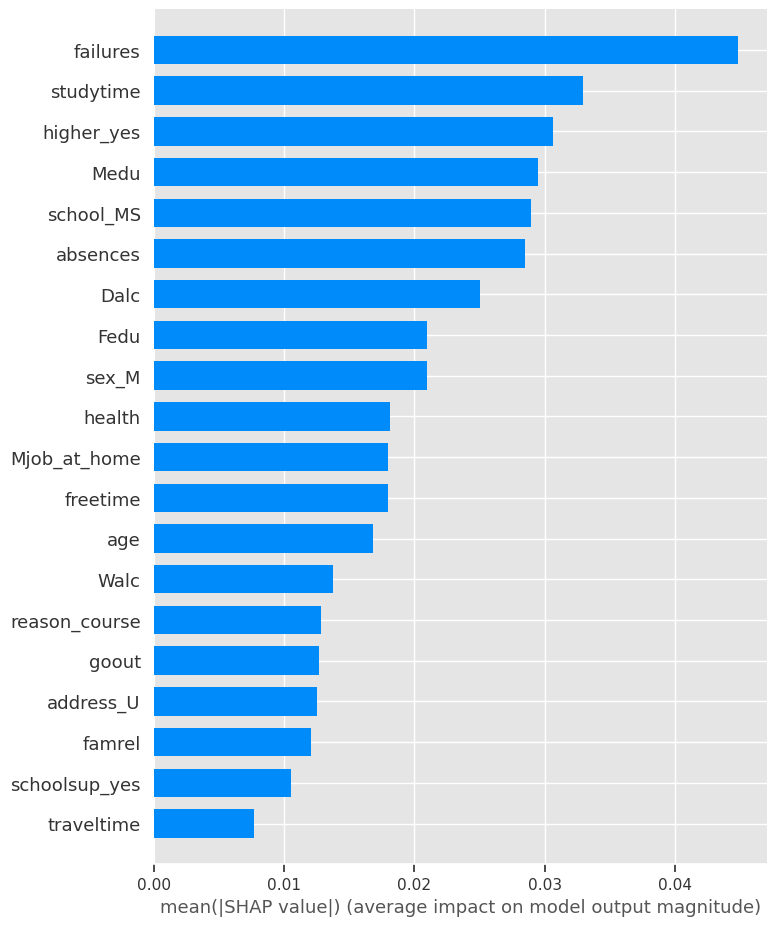

In [32]:
#bar plot summary shows the average of the SHAP value for each feature 
#across all samples.
shap.summary_plot(shap_vals_1,features= X_shap, plot_type='bar')

In [33]:
plot_importance(rf_importances,top_n=10);

NameError: name 'rf_importances' is not defined

## Summary Plot - Dot

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


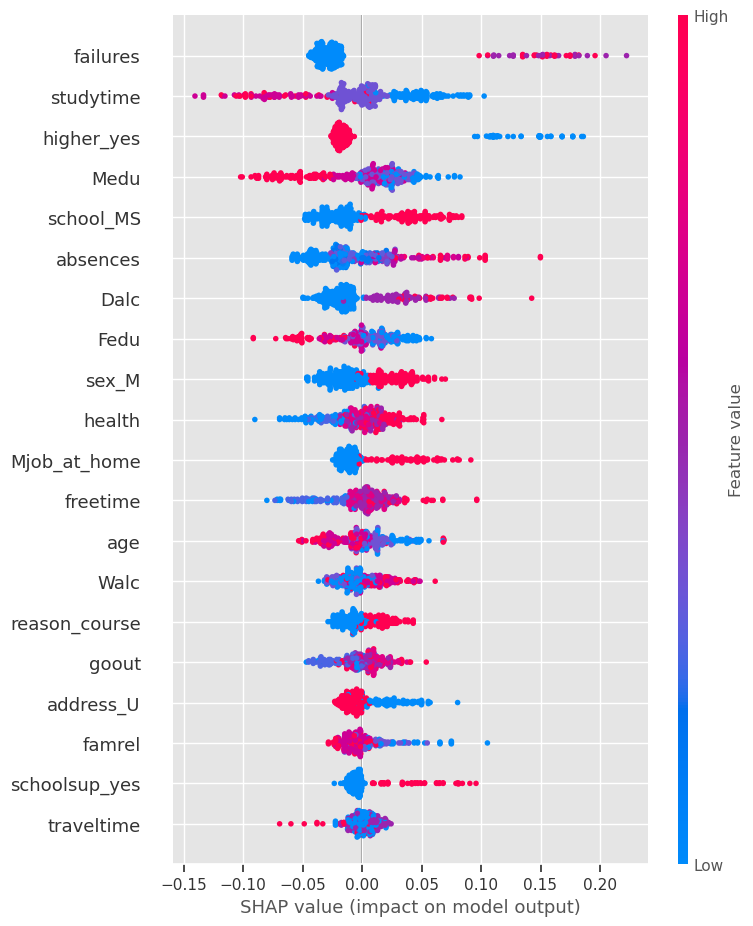

In [34]:
shap.summary_plot(shap_vals_1,X_shap)